In [1]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y_map = {0: 'malignant', 1: 'benign'}

X.shape, y.shape

((569, 30), (569,))

In [2]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
y.value_counts().sort_index()

target
0    212
1    357
Name: count, dtype: int64

In [4]:
X.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis
from sklearn.manifold import TSNE

M = {
    'pca': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', PCA(n_components=2, random_state=37))
    ]),
    'kpca': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', KernelPCA(n_components=2, kernel='rbf', random_state=37))
    ]),
    'fa': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', FactorAnalysis(n_components=2, random_state=37))
    ]),
    'tsne': Pipeline([
        ('scaler', StandardScaler()), 
        ('decomposer', TSNE(n_components=2, n_jobs=-1, random_state=37))
    ])
}

to_df = lambda mat: pd.DataFrame(mat, columns=[f'C{i}' for i in range(mat.shape[1])])
D = {k: to_df(m.fit_transform(X)) for k, m in M.items()}

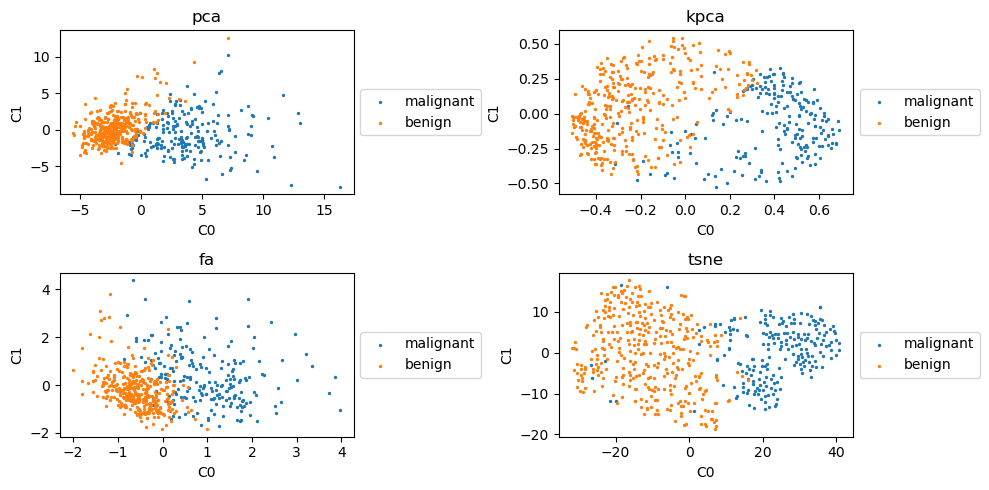

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot(d, k, ax):
    df = d.assign(y=y)
    
    for y_val, color in zip(y.unique(), sns.color_palette('tab10')):
        label = y_map[y_val]
        df[df['y']==y_val].plot(
            kind='scatter', 
            x='C0', 
            y='C1', 
            ax=ax, 
            color=color, 
            label=label,
            s=2
        )
        
    ax.set_title(k)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for k, ax in zip(D.keys(), np.ravel(axes)):
    scatter_plot(D[k], k, ax)

fig.tight_layout()

In [7]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def get_components(algo, regressor='rf'):
    def get_regressor():
        regressors = {
            'linear': lambda: LinearRegression(fit_intercept=False, n_jobs=-1),
            'ridge': lambda: Ridge(fit_intercept=False, random_state=37),
            'lasso': lambda: Lasso(fit_intercept=False, random_state=37),
            'en': lambda: ElasticNet(l1_ratio=0.5, fit_intercept=False, random_state=37),
            'rf': lambda: RandomForestRegressor(random_state=37, n_jobs=-1)
        }
        
        if regressor in regressors:
            return regressors[regressor]
        return regressors['linear']
    
    def get_influence(c):
        r = get_regressor()()
        r.fit(Z, c)
        
        if regressor == 'rf':
            f = r.feature_importances_
        else:
            f = r.coef_
            
        return pd.Series(np.abs(f), index=X.columns)

    Z = M[algo].named_steps['scaler'].transform(X)

    return pd.DataFrame({
            f'{algo}_C0': get_influence(D[algo]['C0']),
            f'{algo}_C1': get_influence(D[algo]['C1'])
        })

def rescale(X):
    S = MinMaxScaler((20, 100)).fit_transform(X)
    
    S = pd.DataFrame(S, columns=X.columns, index=X.index) \
        .assign(**{
            f'__{X.columns[0]}': S[:,0]
        })

    return S

I = get_components('pca') \
    .join(get_components('kpca')) \
    .join(get_components('fa')) \
    .join(get_components('tsne')).T

I = rescale(I)
I

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,__mean radius
pca_C0,20.000000,27.283756,21.037143,20.000000,24.816584,25.001718,64.283432,100.000000,23.065273,20.067127,...,25.333455,30.750942,23.504855,23.485237,57.964365,40.572818,38.724940,26.014307,20.246902,20.000000
pca_C1,22.571806,26.563820,20.773205,47.929244,35.013812,21.698020,20.284749,20.763609,37.414975,100.000000,...,26.866146,35.242397,60.606137,51.687473,38.819089,34.784816,20.215837,34.144849,20.713366,22.571806
kpca_C0,20.149388,60.473926,20.000000,20.069498,34.284320,25.556601,100.000000,24.604016,27.824775,21.136165,...,31.675603,59.915383,36.022357,40.853328,56.878695,32.161050,21.409496,27.834666,20.921186,20.149388
kpca_C1,29.862201,37.933722,22.522415,76.555210,57.318741,22.055121,21.077971,20.554646,35.457608,74.156972,...,31.783550,65.532889,100.000000,49.146433,50.774707,34.462831,20.486978,34.736657,20.521356,29.862201
fa_C0,100.000000,20.000000,100.000000,100.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,100.000000
fa_C1,20.504322,28.518990,20.010106,22.018617,75.560937,100.000000,21.338424,20.422200,57.999974,49.372263,...,24.774784,20.788496,21.754206,64.545860,81.691360,100.000000,20.267472,33.253052,100.000000,20.504322
tsne_C0,20.188206,69.235214,20.188323,20.052242,52.429520,41.109777,29.659389,60.987394,24.330887,20.170578,...,80.978686,100.000000,40.358876,100.000000,100.000000,35.120142,100.000000,27.305729,20.776439,20.188206
tsne_C1,22.454321,100.000000,21.236686,36.816346,100.000000,30.409009,20.524981,21.596044,100.000000,44.822140,...,100.000000,43.938855,40.440353,89.290206,83.518947,68.499308,21.297759,100.000000,23.018739,22.454321


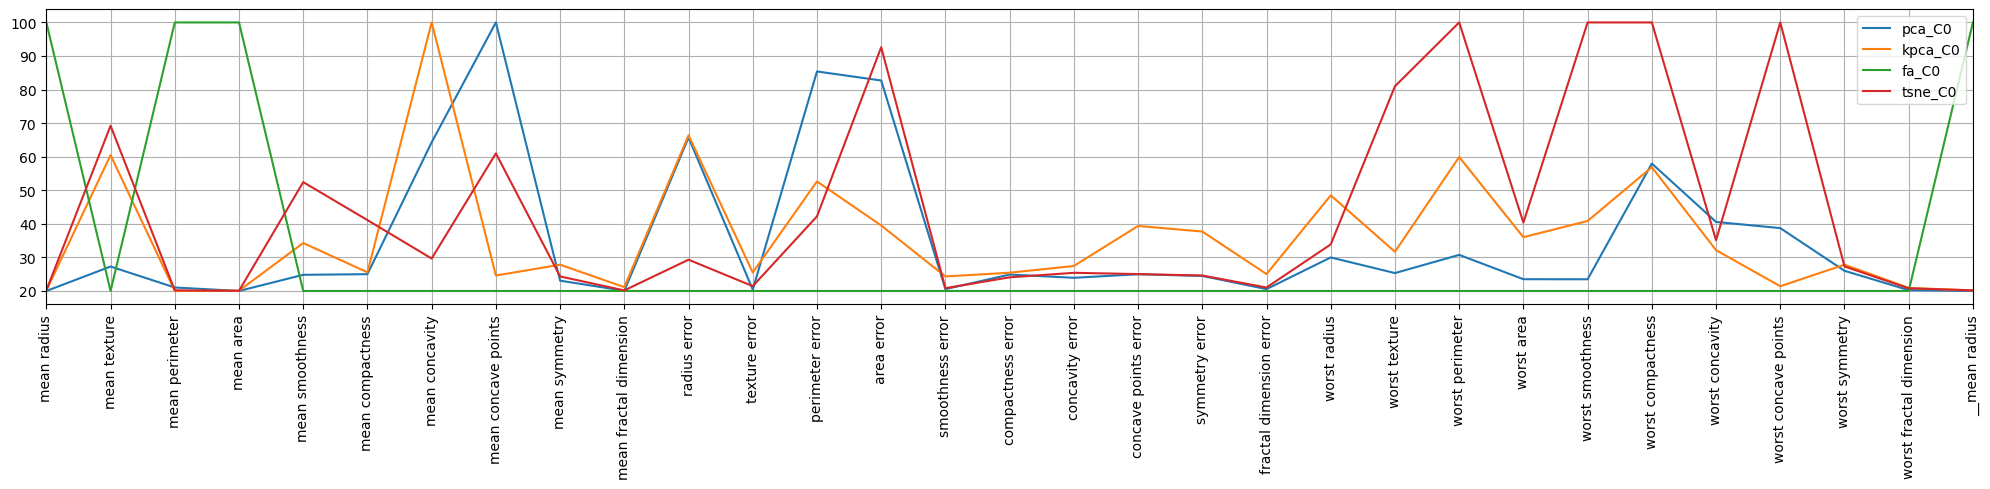

In [23]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)

pd.plotting.parallel_coordinates(
    I.assign(y=I.index)[[True if i.endswith('C0') else False for i in I.index]], 
    'y', 
    color=sns.color_palette('tab10'), 
    sort_labels=False, 
    axvlines=False,
    ax=ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()

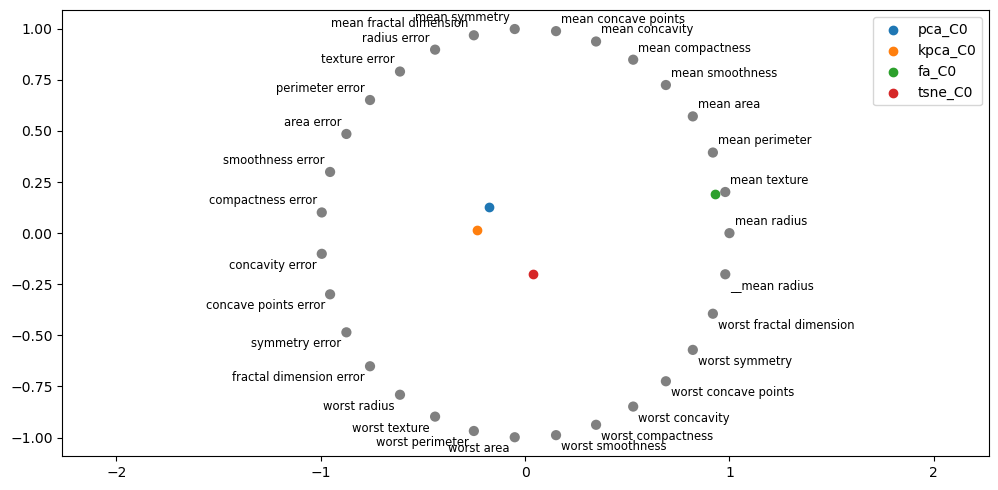

In [29]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

pd.plotting.radviz(
    I.assign(y=I.index)[[True if i.endswith('C0') else False for i in I.index]], 
    'y', 
    color=sns.color_palette('tab10'), 
    ax=ax
)

fig.tight_layout()

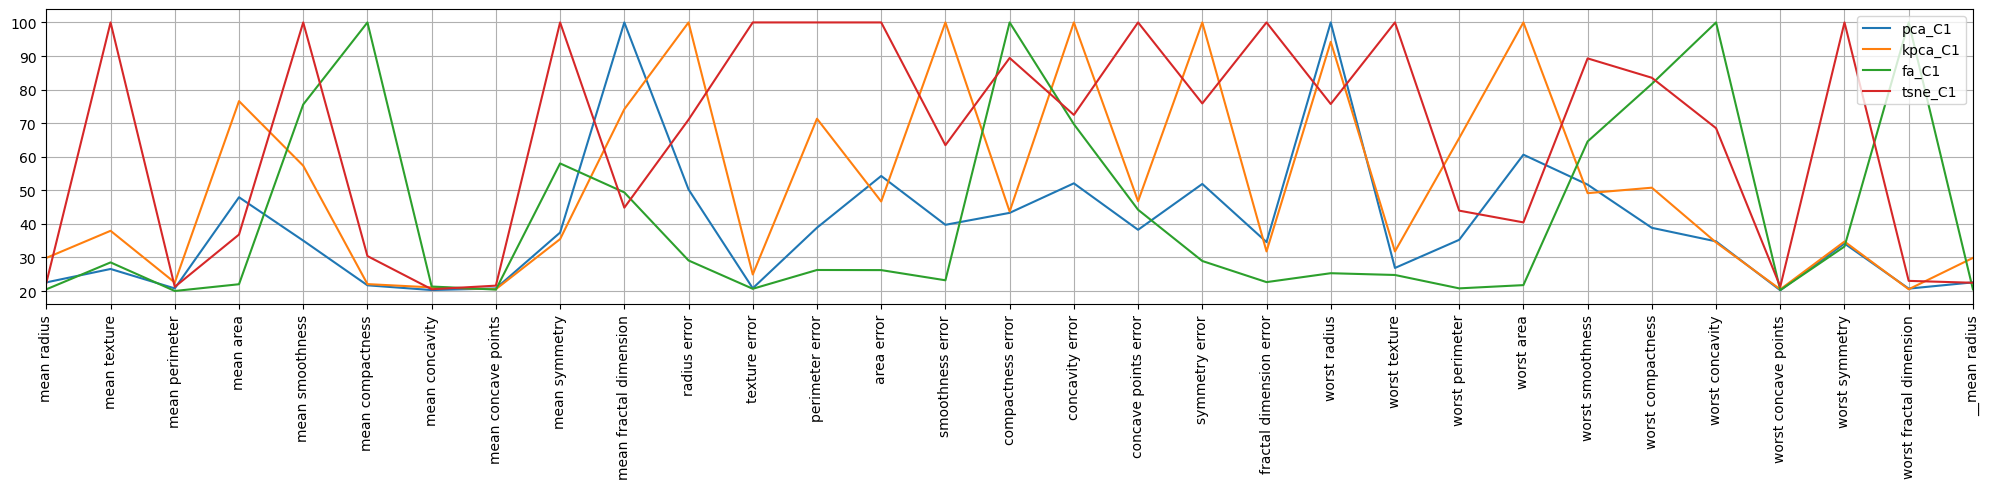

In [30]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)

pd.plotting.parallel_coordinates(
    I.assign(y=I.index)[[True if i.endswith('C1') else False for i in I.index]], 
    'y', 
    color=sns.color_palette('tab10'), 
    sort_labels=False, 
    axvlines=False,
    ax=ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()

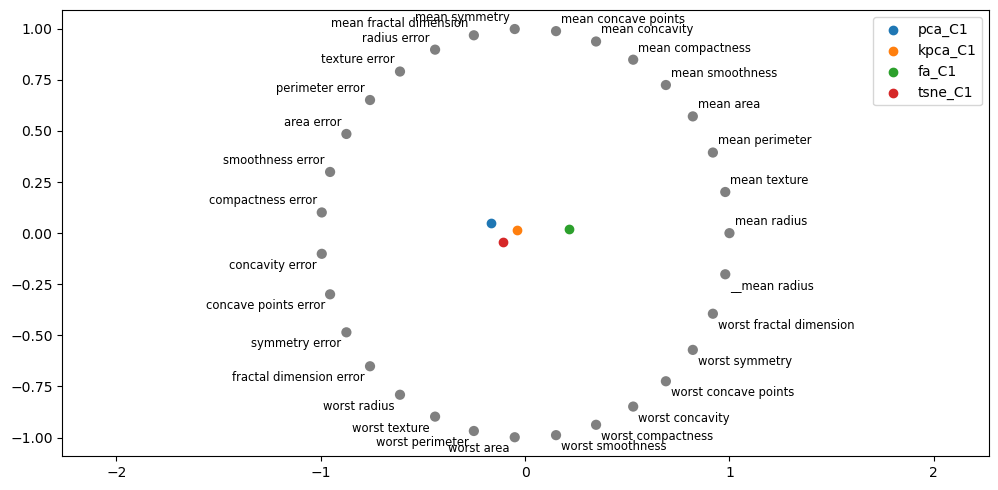

In [31]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

pd.plotting.radviz(
    I.assign(y=I.index)[[True if i.endswith('C1') else False for i in I.index]], 
    'y', 
    color=sns.color_palette('tab10'), 
    ax=ax
)

fig.tight_layout()

In [9]:
from matplotlib.text import Text

def plot_polar(X, markersize=3, linewidth=1, alpha=1.0):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 7))

    d = X.shape[1]
    s = 360 / (d - 1)
    m = s * d + 1

    degrees = np.arange(s, m, s)
    radians = np.deg2rad(degrees)
    
    colors = sns.color_palette('tab10')
    for (name, r), color in zip(X.iterrows(), colors):
        ax.plot(
            radians, 
            r, 
            marker='o', 
            markersize=markersize, 
            linewidth=linewidth, 
            color=color,
            alpha=alpha,
            label=name
        )

    ax.set_yticklabels([])
    ax.set_ylim(0, 150)
    ax.spines['polar'].set_alpha(0.1)

    x2l = {k: v for k, v in zip([0] + list(radians), X.columns[:X.shape[1]-1])}
    x_ticks = [x for x, _ in x2l.items()]
    x_labels = [Text(x, 0, label) for x, label in x2l.items()]

    ax.xaxis.set_ticks(x_ticks)
    ax.xaxis.set_ticklabels(x_labels)
    ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

    for gl in ax.xaxis.get_gridlines():
        gl.set_alpha(0.1)

    for gl in ax.yaxis.get_gridlines():
        gl.set_alpha(0.1)

    fig.tight_layout()

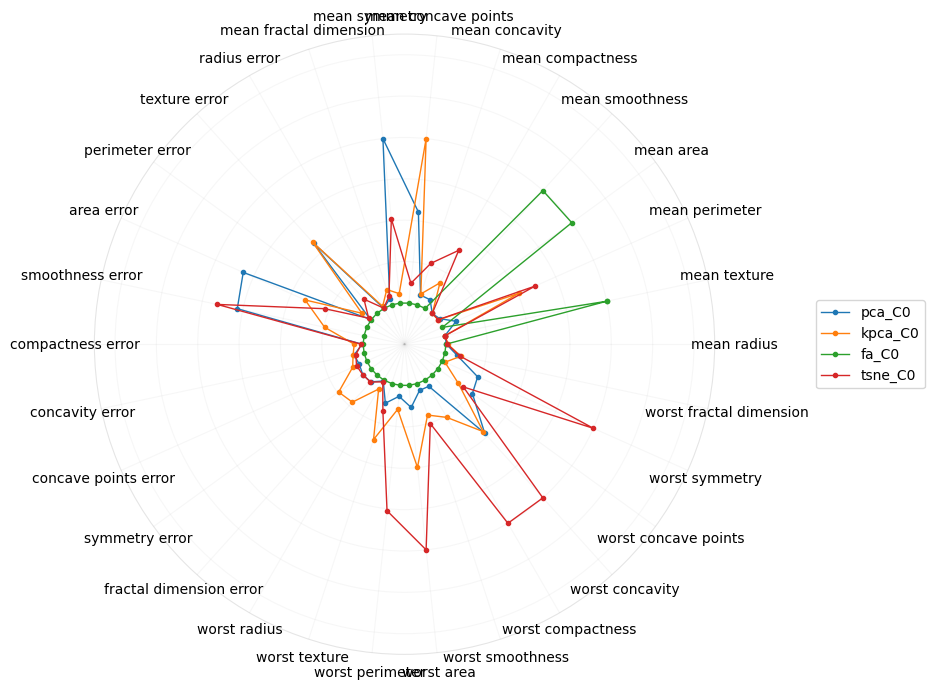

In [10]:
plot_polar(I[[True if i.endswith('C0') else False for i in I.index]])

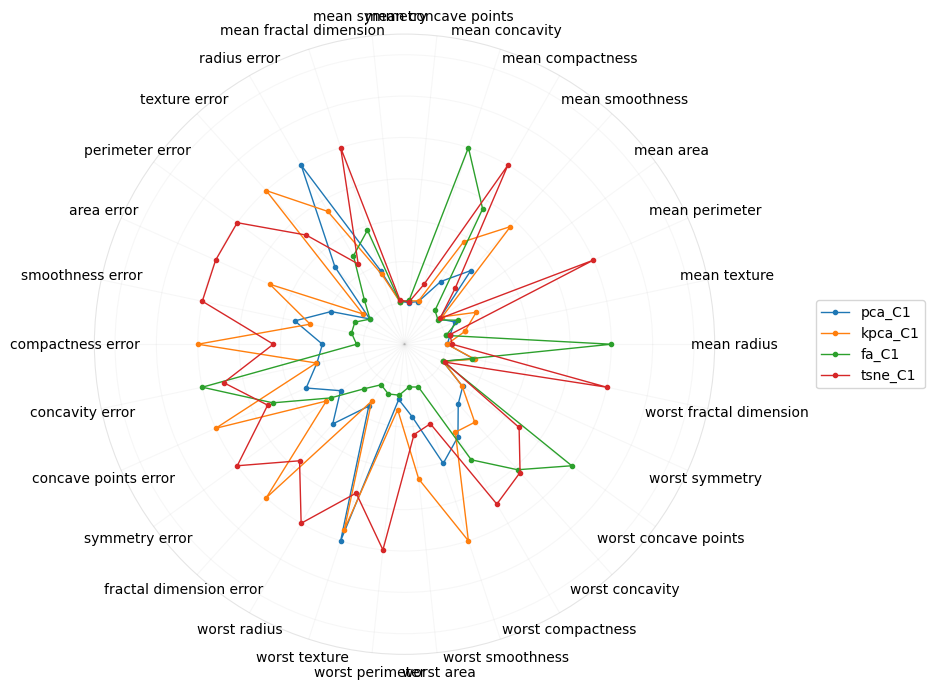

In [11]:
plot_polar(I[[True if i.endswith('C1') else False for i in I.index]])